In [ ]:
pip install ultralytics opencv-python


In [ ]:
!pip uninstall -y torch torchvision torchaudio numpy
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2
!pip install --force-reinstall numpy
!pip install ultralytics --upgrade


In [ ]:
!pip uninstall -y numpy torch torchvision torchaudio
!pip install numpy==1.24.4  # Stable version


In [ ]:
import os
import random
import shutil
import zipfile
import pandas as pd
from ultralytics import YOLO
from sklearn.model_selection import train_test_split

# Paths
ZIP_PATH = "/content/archive.zip"
EXTRACT_PATH = "/content/dataset"

# Extract zip if not already done
if not os.path.exists(EXTRACT_PATH):
    print("Extracting dataset...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)

# Class folders
SHIP_DIR = os.path.join(EXTRACT_PATH, "ship")
NO_SHIP_DIR = os.path.join(EXTRACT_PATH, "no-ship")

# Collect all image paths and labels
all_images = []
for img in os.listdir(SHIP_DIR):
    all_images.append((os.path.join(SHIP_DIR, img), "ship"))
for img in os.listdir(NO_SHIP_DIR):
    all_images.append((os.path.join(NO_SHIP_DIR, img), "no-ship"))

# Create DataFrame
df = pd.DataFrame(all_images, columns=["filepath", "label"])

# Train/Val/Test split
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

# Create YOLO classification folders
for split in ["train", "val", "test"]:
    for class_name in ["ship", "no-ship"]:
        os.makedirs(f"/content/yolo_data/{split}/{class_name}", exist_ok=True)

# Move images into correct folders
def process_split(df, split):
    for _, row in df.iterrows():
        class_name = row["label"]
        dest_dir = os.path.join("/content/yolo_data", split, class_name)
        shutil.copy(row["filepath"], os.path.join(dest_dir, os.path.basename(row["filepath"])))

process_split(train_df, "train")
process_split(val_df, "val")
process_split(test_df, "test")

# Train YOLOv8 classification model
model = YOLO("yolov8n-cls.pt")
model.train(data="/content/yolo_data", epochs=10, imgsz=640)

# Evaluate model
metrics = model.val()
print(metrics)


Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.0.1+cu117 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/yolo_data, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

train: Scanning /content/yolo_data/train... 3200 images, 0 corrupt: 100%|██████████| 3200/3200 [00:00<?, ?it/s]
val: Scanning /content/yolo_data/val... 400 images, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/classify/train2
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:46<00:00,  3.55s/it]

                   all       0.79          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:49<00:00,  3.84s/it]

                   all       0.95          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:47<00:00,  3.68s/it]

                   all      0.973          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:44<00:00,  3.39s/it]

                   all      0.962          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:52<00:00,  4.01s/it]

                   all      0.995          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:46<00:00,  3.60s/it]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:51<00:00,  3.98s/it]

                   all          1          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:49<00:00,  3.83s/it]

                   all      0.993          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:52<00:00,  4.01s/it]

                   all          1          1

      Epoch    GPU_mem       loss  Instances       Size



      10/10         0G    0.09487         16        640: 100%|██████████| 200/200 [18:31<00:00,  5.56s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:47<00:00,  3.63s/it]

                   all          1          1

10 epochs completed in 3.252 hours.
Optimizer stripped from runs/classify/train2/weights/last.pt, 3.0MB


Optimizer stripped from runs/classify/train2/weights/best.pt, 3.0MB

Validating runs/classify/train2/weights/best.pt...
Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.0.1+cu117 CPU (Intel Xeon 2.20GHz)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/yolo_data/train... found 3200 images in 2 classes ✅ 
val: /content/yolo_data/val... found 400 images in 2 classes ✅ 
test: /content/yolo_data/test... found 400 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:43<00:00,  3.33s/it]


                   all          1          1
Speed: 0.0ms preprocess, 95.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2
Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.0.1+cu117 CPU (Intel Xeon 2.20GHz)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/yolo_data/train... found 3200 images in 2 classes ✅ 
val: /content/yolo_data/val... found 400 images in 2 classes ✅ 
test: /content/yolo_data/test... found 400 images in 2 classes ✅ 


val: Scanning /content/yolo_data/val... 400 images, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 25/25 [00:37<00:00,  1.51s/it]


                   all          1          1
Speed: 0.0ms preprocess, 81.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train22
ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a293f1fc650>
curves: []
curves_results: []
fitness: 1.0
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 1.0, 'metrics/accuracy_top5': 1.0, 'fitness': 1.0}
save_dir: PosixPath('runs/classify/train22')
speed: {'preprocess': 0.0012428449963408639, 'inference': 81.47799618001045, 'loss': 7.165750048443442e-05, 'postprocess': 0.00024414751351287123}
task: 'classify'
top1: 1.0
top5: 1.0


KeyError: 'metrics/precision(B)'

🔍 Predicting on 400 test images...


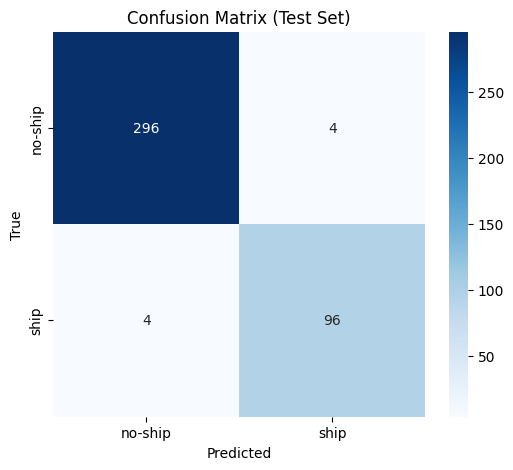

📝 Classification Report (Test Set):

              precision    recall  f1-score   support

     no-ship       0.99      0.99      0.99       300
        ship       0.96      0.96      0.96       100

    accuracy                           0.98       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.98      0.98      0.98       400

✅ Test Set Accuracy: 98.00%


In [ ]:
import os
import glob
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- STEP 1: Get all test images and true labels ---
test_image_paths = glob.glob("/content/yolo_data/test/*/*.png")  # or .png
true_labels = [path.split("/")[-2] for path in test_image_paths]  # folder name is label

# Map class names to indices
class_names = sorted(list(set(true_labels)))
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

# --- STEP 2: Run predictions on all test images ---
predicted_labels = []

print(f"🔍 Predicting on {len(test_image_paths)} test images...")

for path in test_image_paths:
    result = model.predict(path, verbose=False)[0]
    pred_class = result.names[result.probs.top1]
    predicted_labels.append(pred_class)

# --- STEP 3: Evaluate ---
true_indices = [class_to_idx[label] for label in true_labels]
predicted_indices = [class_to_idx[label] for label in predicted_labels]

# Confusion Matrix
cm = confusion_matrix(true_indices, predicted_indices)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.show()

# Classification Report
report = classification_report(true_indices, predicted_indices, target_names=class_names)
print("Classification Report (Test Set):\n")
print(report)

# Accuracy
correct = np.sum(np.array(true_indices) == np.array(predicted_indices))
total = len(true_indices)
accuracy = correct / total
print(f"Test Set Accuracy: {accuracy * 100:.2f}%")
